In [1]:
%matplotlib inline
import matplotlib
print('matplotlib version:', matplotlib.__version__)
import matplotlib.pyplot as plt

import numpy as np
print('numpy version', np.__version__)
from numpy import median

import pandas as pd
print('pandas version:', pd.__version__)
from pandas import ExcelWriter
from pandas import ExcelFile

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols #加载ols模型
from statsmodels.formula.api import poisson
print('statsmodels version:', sm.__version__)

import dowhy
from dowhy import CausalModel
import dowhy.datasets
print('dowhy version:', dowhy.__version__)

# Avoiding unnecessary log messges and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

print('Concact: Zehua Zeng (starlitnightly@163.com)')

matplotlib version: 3.5.1
numpy version 1.22.4
pandas version: 1.4.3
statsmodels version: 0.13.2
dowhy version: 0.7.1
Concact: Zehua Zeng (starlitnightly@163.com)


In [2]:
fish_data=pd.read_csv('data/fish_data.csv')
fish_data.head()

,Time,A,B,C,ndr1,ndr2,treatment
0,3.7,1,1,1,9166.98,4351.54,1
1,3.7,1,1,0,7525.59,4074.69,0
2,4.0,1,1,1,11753.21,6031.75,1
3,4.0,1,1,0,8580.33,6099.13,0
4,4.3,1,1,1,13392.53,10041.42,1


# 1. linear regression model analysis

In [5]:
from patsy import dmatrices
y, X = dmatrices('ndr1 ~ Time+A+B+C', data=fish_data, return_type="dataframe")
model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   ndr1   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     6.521
Date:                Wed, 13 Jul 2022   Prob (F-statistic):           0.000628
Time:                        17:02:30   Log-Likelihood:                -334.11
No. Observations:                  36   AIC:                             678.2
Df Residuals:                      31   BIC:                             686.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8799.7445   3222.356      2.731      0.0

In [6]:
from patsy import dmatrices
y, X = dmatrices('ndr2 ~ Time+A+B+C', data=fish_data, return_type="dataframe")
model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   ndr2   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     6.560
Date:                Wed, 13 Jul 2022   Prob (F-statistic):           0.000603
Time:                        17:02:38   Log-Likelihood:                -342.98
No. Observations:                  36   AIC:                             696.0
Df Residuals:                      31   BIC:                             703.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7541.2095   4122.549     -1.829      0.0

# 2. casual inference

## 2.1 ndr1

In [21]:
data={
    'df':fish_data,
    'outcome_name':'ndr1',
    'treatment_name':['B','C','Time'],
    'common_causes_names':['ndr2','A',],
    #'instrument_names':['Time'], 
    "time_val":['Time'],
}

In [8]:
model = CausalModel(
    data=data["df"],
    treatment=data['treatment_name'],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    #instruments=data["instrument_names"]
)

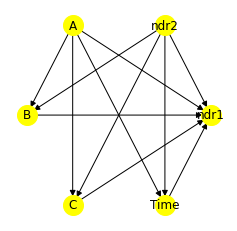

In [9]:
model.view_model(layout='dot', size=(4, 4),file_name='result/causal_model_ndr1')

### 2.1.1 estimand construct

In [10]:
# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                      
─────────────(E[ndr1|ndr2,A])
d[B  C  Time]                
Estimand assumption 1, Unconfoundedness: If U→{B,C,Time} and U→ndr1 then P(ndr1|B,C,Time,ndr2,A,U) = P(ndr1|B,C,Time,ndr2,A)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [11]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                      
─────────────(E[ndr1|ndr2,A])
d[B  C  Time]                
Estimand assumption 1, Unconfoundedness: If U→{B,C,Time} and U→ndr1 then P(ndr1|B,C,Time,ndr2,A,U) = P(ndr1|B,C,Time,ndr2,A)

## Realized estimand
b: ndr1~B+C+Time+ndr2+A
Target units: ate

## Estimate
Mean value: 2123.4898960496703

Causal Estimate is 2123.4898960496703


### 2.1.2 refute test

In [13]:
#random
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

In [14]:
### placebo
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

In [15]:
### subset
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

## 2.2 ndr2

In [24]:
data={
    'df':fish_data,
    'outcome_name':'ndr2',
    'treatment_name':['A','C','Time'],
    'common_causes_names':['ndr1','B'],
    #'instrument_names':['Time'], 
    "time_val":['Time'],
}

In [25]:
model = CausalModel(
    data=data["df"],
    treatment=data['treatment_name'],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    #instruments=data["instrument_names"]
)

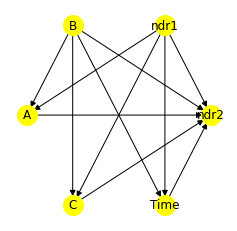

In [26]:
model.view_model(layout='dot', size=(4, 4),file_name='result/causal_model_ndr2')

### 2.2.1 estimand construct

In [27]:
# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                      
─────────────(E[ndr2|B,ndr1])
d[A  C  Time]                
Estimand assumption 1, Unconfoundedness: If U→{A,C,Time} and U→ndr2 then P(ndr2|A,C,Time,B,ndr1,U) = P(ndr2|A,C,Time,B,ndr1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [28]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                      
─────────────(E[ndr2|B,ndr1])
d[A  C  Time]                
Estimand assumption 1, Unconfoundedness: If U→{A,C,Time} and U→ndr2 then P(ndr2|A,C,Time,B,ndr1,U) = P(ndr2|A,C,Time,B,ndr1)

## Realized estimand
b: ndr2~A+C+Time+B+ndr1
Target units: ate

## Estimate
Mean value: 7259.742222668288

Causal Estimate is 7259.742222668288


### 2.2.2 refute test

In [29]:
#random
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

In [30]:
### placebo
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

In [31]:
### subset
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

## 2.3 ndr1 review advice

In [11]:
data={
    'df':fish_data,
    'outcome_name':'ndr1',
    'treatment_name':['A','C','B','Time'],
    'common_causes_names':['ndr2'],
    #'instrument_names':['Time'], 
    "time_val":['Time'],
}

In [12]:
model = CausalModel(
    data=data["df"],
    treatment=data['treatment_name'],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    #instruments=data["instrument_names"]
)

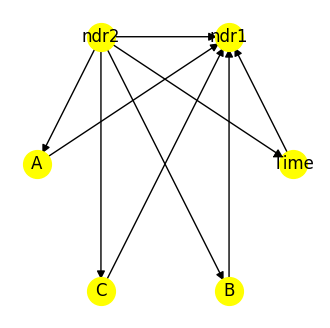

In [13]:
model.view_model(layout='dot', size=(4, 4),file_name='result/causal_model_ndr2')

### 2.3.1 estimand construct

In [14]:
# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                      
────────────────(E[ndr1|ndr2])
d[A  C  B  Time]              
Estimand assumption 1, Unconfoundedness: If U→{A,C,B,Time} and U→ndr1 then P(ndr1|A,C,B,Time,ndr2,U) = P(ndr1|A,C,B,Time,ndr2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [15]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                      
────────────────(E[ndr1|ndr2])
d[A  C  B  Time]              
Estimand assumption 1, Unconfoundedness: If U→{A,C,B,Time} and U→ndr1 then P(ndr1|A,C,B,Time,ndr2,U) = P(ndr1|A,C,B,Time,ndr2)

## Realized estimand
b: ndr1~A+C+B+Time+ndr2
Target units: ate

## Estimate
Mean value: -381.6345989704714

Causal Estimate is -381.6345989704714


### 2.3.2 refute test

In [18]:
#random
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

In [19]:
### placebo
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

In [20]:
### subset
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

## 2.4 ndr2 review advice

In [3]:
data={
    'df':fish_data,
    'outcome_name':'ndr2',
    'treatment_name':['A','C','B','Time'],
    'common_causes_names':['ndr1'],
    #'instrument_names':['Time'], 
    "time_val":['Time'],
}

In [4]:
model = CausalModel(
    data=data["df"],
    treatment=data['treatment_name'],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    #instruments=data["instrument_names"]
)

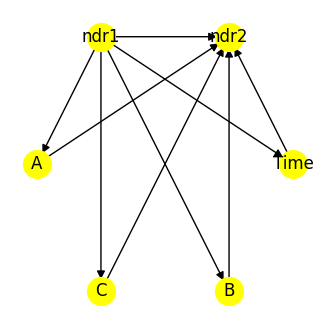

In [5]:
model.view_model(layout='dot', size=(4, 4),file_name='result/causal_model_ndr2')

### 2.4.1 estimand construct

In [6]:
# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                      
────────────────(E[ndr2|ndr1])
d[A  C  B  Time]              
Estimand assumption 1, Unconfoundedness: If U→{A,C,B,Time} and U→ndr2 then P(ndr2|A,C,B,Time,ndr1,U) = P(ndr2|A,C,B,Time,ndr1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [7]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                      
────────────────(E[ndr2|ndr1])
d[A  C  B  Time]              
Estimand assumption 1, Unconfoundedness: If U→{A,C,B,Time} and U→ndr2 then P(ndr2|A,C,B,Time,ndr1,U) = P(ndr2|A,C,B,Time,ndr1)

## Realized estimand
b: ndr2~A+C+B+Time+ndr1
Target units: ate

## Estimate
Mean value: 7093.753093275986

Causal Estimate is 7093.753093275986


### 2.4.2 refute test

In [8]:
#random
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

In [9]:
### placebo
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(res_placebo)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarni

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarni

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/fernandozeng/miniforge3/envs/django/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1918: RuntimeWarni

In [10]:
### subset
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate